<a href="https://colab.research.google.com/github/JohnnyKyr/CompIntel-Projects/blob/main/GAs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/drive')

import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from math import log2
import random
import numpy as np
import math
from scipy import sparse

Mounted at /drive


In [ ]:
class Parser:

    def __init__(self):
        self.dataMatrix = None
        self.labels = None
        self.size = None

    def getLexicalSize(self,file):
        lexiconS = []
        with open(file, "r") as fp:
            for line in fp:
                lexiconS.append(line.split()[0])
        return  len(lexiconS)
    def getLabels(self,data):
        self.labels = []
        with open(data, "r") as fp:
            for line in fp:
                self.labels.append([int(i) for i in line.split()])

    def getData(self,data,lexicon):
        bagof = []
        bagofcsr =[]
        with open(data,"r") as fp:
            for line in fp:
                vertex = [0 for i in range(self.getLexicalSize(lexicon))]
                array = list(filter(lambda x : x[0] != '<' , line.split()))
                for ele in array:
                    vertex[int(ele)] +=1
                self.size = len(vertex)
                bagof.append(vertex)
        return bagof


In [ ]:

datalex = Parser()


bagofwords = datalex.getData("/drive/MyDrive/ML/train-data.dat","/drive/MyDrive/ML/vocabs.txt")



In [ ]:

def tf_idf(bagofwords,verbose=0):
  count=0
  N=len(bagofwords)
  n = len(bagofwords[0])
  tfbag = []
  
  textDCount = np.count_nonzero(bagofwords,axis=0)  #word count of the text body
  worddcount = np.count_nonzero(bagofwords,axis=1) #word count for each text
  
  #----------------IDF----------------------
  _idf = [0 for _ in range(len(textDCount))]
  tf_idf= []
  for k,value in enumerate(textDCount):
    _idf[k] = np.log10(N/value)
  _idf = np.array(_idf)
  #---------------TF-----------------------
  tfDict = [0 for _ in range(N)]
  for i in range(N):
    count+=1
    tfDict[i] = np.array([(text/worddcount[i]) for k,text in enumerate(bagofwords[i])])
    if verbose==1:
      print("======================================")
      print("Finished",count,"st","Calculation")
  
  tfDict = np.array(tfDict)
  
  
  for ele in tfDict:
    tf_idf.append(ele*_idf)
  
  avg = np.mean(tf_idf, axis = 0)
  return avg
   

tf__idf = tf_idf(bagofwords)

maximum = 0
for ele in tf__idf:
  maximum+=ele

In [96]:
class Individual(object):
    def __init__(self, chromosome):
        self.chromosome = chromosome
        self.fitness = self.fitnessFunc()

    @classmethod
    def create_genome(self):

        genome = np.random.randint(0, 1, size=8520)
        rand_ones = random.randint(0, 8519)
        for _ in range(rand_ones):
          index = random.randint(0, 8519)
          while genome[index] == 1:
            index = random.randint(0, 8519)
          else:
            genome[index] = 1
        return genome


    def fitnessFunc(self):
    #Calculating the fittest with the best sum of avg in tf_idf
    #Sort population by nonzero
      global maximum
      global tf__idf
      fitness = 0
      if np.count_nonzero(self.chromosome)>2000:
        per = (np.count_nonzero(self.chromosome)//100)/100
        fitness -=per*maximum
      else:
        for value in np.nonzero(self.chromosome)[0]:
          fitness += tf__idf[value]
      return fitness

def genome_rejection(genome: Individual):
    # replace the non valid genome
    # TODO recursion
    while np.count_nonzero(genome) < 1000:
        genome = Individual.create_genome()
    return genome


def repair_genome(genome: Individual):
    nnz = np.count_nonzero(genome)
    while nnz < 1000:
        difference = 1000 - nnz
        for _ in range(difference):
            genome[random.randint(0, 8519)] = 1
        nnz = np.count_nonzero(genome)
    return genome

def initialize_population(no_of_chromosomes):
    population = []
    for _ in range(no_of_chromosomes):
        genome = Individual.create_genome()
        # genome = genome_rejection(genome)
        genome = repair_genome(genome)
        population.append(Individual(genome))

    return population


    
  
  

def RouleteWheelSelection(population):
  s=0
  population_fitness = sum([individual.fitness for individual in population])
  r = random.randint(0, int(population_fitness))
  prob = [individual.fitness/population_fitness for individual in population]
  
  for individual in population:
    s+=individual.fitness
    if s>=r:
      return individual

def TournamentSelection(population):
  K =  random.randint(1, len(population))
  k_individuals = []
  for _ in range(K):
    k_individuals.append(population[random.randint(0, len(population)-1)])
  k_individuals.sort(key = lambda x:x.fitness)

  return k_individuals[-1]

def Crossover(parent1,parent2,prob,k=6):
  if random.random() <=prob:
    points = [np.random.randint(0,len(parent1.chromosome)) for _ in range(k)]
    points.sort()
    
    for i in points:
      A=np.append(parent1.chromosome[:i],parent2.chromosome[i:])
      B=np.append(parent2.chromosome[:i],parent1.chromosome[i:])
    return Individual(A),Individual(B)
  else:
    return parent1,parent2

def Repetition(old,new,rpgenome):

  if old:
    if np.array_equal(old.chromosome,new.chromosome):
      rpgenome +=1
    
    if new.fitness > old.fitness:
      old = new
      rpgenome=1
  else:
    old = new
  return rpgenome,old

def mutate(child: Individual, p_mutate):
  for i in range(len(child.chromosome)):
    if random.random() < p_mutate:
      child.chromosome[i] = 1-child.chromosome[i]
  child.fitnessFunc()
      

def Main():
  POPULATION_SIZE = 100
  generations = 0
  best =[]
  end = False
  population = initialize_population(POPULATION_SIZE)
  best_individual = None
  new_best = None
  
  repeated_genome = 0
  while not end:

    if generations==1000:
      end = True

    
    
    if repeated_genome >=50:
      end=True
      print("Interrupt after repitition")

    

    new_generation = []
    population = sorted(population, key = lambda x:x.fitness,reverse = True)
    
    new_best = population[0]
    
    repeated_genome,best_individual = Repetition(best_individual,new_best,repeated_genome)

    s = int((10*POPULATION_SIZE)/100)
    new_generation.extend(population[:s])
    print("\n",new_generation[0].fitness,new_generation[-1].fitness,"\n")
   
    best.append(best_individual)
    x = int((90*POPULATION_SIZE)/100)
    
    for _ in range(x//2):
      parent1 = TournamentSelection(population)
      parent2 = TournamentSelection(population)
      offspring1,offspring2 = Crossover(parent1,parent2,1)
      mutate(offspring1,0.10)
      mutate(offspring2,0.10)
      new_generation.append(offspring1)
      new_generation.append(offspring2)
    
    print("Generation:",generations,"Best_individual:",best_individual.fitness,len(new_generation))
    population = new_generation
    generations+=1
  return best,generations




 0.45422022946322776 0.2672942199724046 

Generation: 0 Best_individual: 0.45422022946322776 100

 0.4623180672253538 0.45584458180583093 

Generation: 1 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 2 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 3 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 4 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 5 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 6 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 7 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 8 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.45584458180583093 

Generation: 9 Best_individual: 0.4623180672253538 100

 0.4623180672253538 0.455844

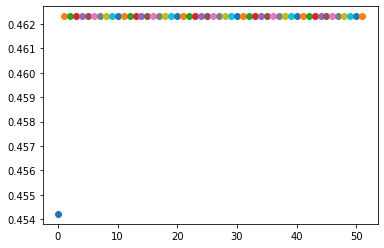

In [99]:
import matplotlib.pyplot as plt
if __name__ == "__main__":
  best,generations = Main()

  for i in range(generations):
    plt.scatter(i,best[i].fitness) 

In [ ]:
population = initialize_population(POPULATION_SIZE)


0.39839330245908233
1665
0.8047941529760048
1712
